# Investigate Stun Effect using datasets with variable implantation date

In [1]:
%load_ext autoreload
%autoreload 2
from analysis_settings import *
from plot_settings import *
from scripts.utils_plot import plot_corrs, explode_df, _save_fig
import pandas as pd
import scripts.config as cfg
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import wilcoxon
from scripts.utils_plot import convert_pvalue_to_asterisks

In [2]:
dataframes = get_dfs('ch_dist_sweet')
df = dataframes['df_abs']
df = df[df['project_nme'] != 'all']

/Users/moritzgerster/Library/CloudStorage/Dropbox/Code/STN_broadband_power/notebooks/analysis_settings.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['sub_hemi_cond'] = df.sub_hemi + '_' + df.cond
/Users/moritzgerster/Library/CloudStorage/Dropbox/Code/STN_broadband_power/notebooks/analysis_settings.py:81: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pivot['UPDRS_exists'] = pivot.UPDRS_bradyrigid_contra.notna()
/Users/moritzgerster/Library/CloudStorage/Dropbox/Code/STN_broadband_power/notebooks/analysis_settings.py:82: 

# Pre post difference

In [3]:
def stat_anno(ax, df, x, y, groupby='subject', alternative='two-sided',
              y_line=None):
    ymin, ymax = ax.get_ylim()
    yscale = np.abs(ymax - ymin)
    y_buffer = 0.05*yscale

    # Draw the line connecting the two bars
    x1, x2 = ax.get_xticks()
    if y_line is None:
        y_line = ymax + y_buffer
    ax.plot([x1, x1, x2, x2],
                [y_line, y_line + y_buffer/2, y_line + y_buffer/2, y_line],
                color='black')

    # Get the significance text based on the p-value
    vals = df.copy().sort_values([groupby, x]).groupby(groupby)[y]
    xy_diff = vals.diff().dropna()
    pvalue = wilcoxon(xy_diff, alternative=alternative)[1]
    print(pvalue)
    text = convert_pvalue_to_asterisks(pvalue, print_ns=True)

    # Place the text above the line
    y_text = y_line + y_buffer/2  # Add a little more offset for the asterisks
    ax.text((x1 + x2) / 2, y_text, text,
                ha='center', va='bottom', fontsize=FONTSIZE_ASTERISK)

    if y_line is None:
        ax.set_ylim([ymin-y_buffer, ymax+4*y_buffer])

0.0011758804321289062
0.019441962242126465
0.5661587399431929
0.1901561336524058
0.000133514404296875
0.01168079231908592


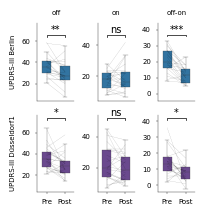

In [4]:
conds = ['off', 'on', 'offon_abs']

fig, axes = plt.subplots(2, len(conds), figsize=(2, 2.1), sharey='col')

for col, cond in enumerate(conds):

    df_cond = df[df['cond'] == cond]

    # Filter to include only subjects with both pre and post scores
    df_both = df_cond.drop_duplicates(subset=['subject'])
    df_both = df_both[(df_both['UPDRS_pre_III'].notna())
                    & (df_both['UPDRS_post_III'].notna())]

    # Reshape data to long format for plotting
    df_long = pd.melt(df_both,
                    id_vars=['project_nme', 'subject'],
                    value_vars=['UPDRS_pre_III', 'UPDRS_post_III'],
                    var_name='Assessment',
                    value_name='UPDRS_III_Score')

    # Map assessment names to 'Pre' and 'Post' for easier plotting
    rename = {'UPDRS_pre_III': 'Pre', 'UPDRS_post_III': 'Post'}
    df_long['Assessment'] = df_long['Assessment'].map(rename)
    projects = [proj for proj in cfg.PROJECT_NAMES
                if proj in df_long.project_nme.unique()]


    # Loop through each project and plot on separate axes
    for row, project in enumerate(projects):
        ax = axes[row, col]
        df_proj = df_long[df_long['project_nme'] == project]

        # Plot boxplot for Pre and Post scores
        width = 0.5
        sns.boxplot(data=df_proj, x='Assessment', y='UPDRS_III_Score',
                    ax=ax, color=cfg.COLOR_DIC[project], showfliers=False,
                    linewidth=0.2,
                    width=width
                    )

        # Add lines connecting paired pre and post scores for each subject
        for sub in df_proj.subject.unique():
            df_sub = df_proj[df_proj['subject'] == sub]
            # jitter = np.random.uniform(-width/4, width/4, size=len(df_sub))  # Adjust the range for more/less jitter
            # x_jittered = np.array([0, 1]) + jitter  # 0 for 'Pre' and 1 for 'Post'

            # ax.plot(x_jittered, df_sub['UPDRS_III_Score'], marker='.',
            ax.plot([0, 1], df_sub['UPDRS_III_Score'], marker='o',
                    markersize=.00005, color='k', lw=0.05)

        # Run Wilcoxon signed-rank test and annotate p-value
        stat_anno(ax, df_proj, 'Assessment', 'UPDRS_III_Score', y_line=None)

        # Customize each axis
        ax.set_ylabel(f'UPDRS-III {project}' if col == 0 else '')
        ax.set_xlabel(None)
        if row == 0:
            ax.set_title(f'{cfg.COND_DICT[cond]}', y=1.)
            ax.set_xticks([])
        else:
            ax.set_title(None)
        ax.set_xlim(-.5, 1.5)

# remove y-axis:
# axes[1].get_yaxis().set_ticks([])
# axes[1].spines['left'].set_visible(False)

# fig.supxlabel('Assessment')
plt.tight_layout()
save_dir = f'{SAVE_DIR}/Figure1/'
_save_fig(fig, f'stun_effect_UPDRS_III_{'_'.join(conds)}.pdf', save_dir, close=False,
          bbox_inches=None)
plt.show()